In this assignment we implement an ensemble method: Stacking.
We are going to train a neural network and a decision tree first, and then use their predictions as input to a second classifier: Logistic Regression.

We start as usual with installing some software.


In [ ]:
# SETUP
# install python at version 3.10
!apt-get install python3.10

# update symbolic links to the newly installed python version
!ln -sf /usr/bin/python3.10 /usr/bin/python
!ln -sf /usr/bin/python3.10 /usr/bin/python3

# install scikit-learn 1.2.2
%pip install scikit-learn==1.2.2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.10 is already the newest version (3.10.12-1~22.04.3).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


Next we create a corpus and extract a train, a validation and a test set.

In [ ]:
import numpy as np
import random
import tensorflow as tf
from sklearn.datasets import make_blobs
from tensorflow.python.framework.random_seed import set_random_seed
from keras import initializers
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input
from keras.utils import to_categorical
from tensorflow.python.framework.random_seed import set_random_seed

X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
trainX, valtestX, trainy, valtesty = train_test_split(X, y, train_size=0.1, shuffle=False)
valX, testX, valy, testy = train_test_split(valtestX, valtesty, train_size=0.112, shuffle=False)
trainy_cat, valy_cat, testy_cat = to_categorical(trainy), to_categorical(valy), to_categorical(testy)

print(trainX.shape, valX.shape, testX.shape)

random.seed(42)
np.random.seed(42)
set_random_seed(42)


(110, 2) (110, 2) (880, 2)


**Exercise 2.1**

Let's train a Neural Network on the training set trainX.
The network uses:

*   an input layer, an hidden layer of dimension 25 with RELU activation function, an output layer of dimension 3 with softmax activation
*   categorical cross entropy as loss
*   adam as optimizer
*   valX as validation set. The option to the command fit for doing this is "validation_data=(valX, valy_cat)"
*   train for 500 epochs



In [ ]:
# Add your code here
tf.config.experimental.enable_op_determinism()

#define input size, and number of classes
feature_vector_length = trainX.shape[1]
num_classes = 3

#define the model
nn_model = Sequential()

#add layers layer
nn_model.add(Dense(input_dim = feature_vector_length, units = 25, activation='relu')) #hidden layer
nn_model.add(Dense(num_classes, activation='softmax')) #output layer

#compile the model
nn_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

#history
history = nn_model.fit(trainX, trainy_cat, epochs=500, verbose=1, validation_data = (valX, valy_cat))

Epoch 1/500
4/4 [==============================] - 1s 77ms/step - loss: 1.3274 - accuracy: 0.2909 - val_loss: 1.2053 - val_accuracy: 0.4091
Epoch 2/500
4/4 [==============================] - 0s 11ms/step - loss: 1.2233 - accuracy: 0.2909 - val_loss: 1.1257 - val_accuracy: 0.3909
Epoch 3/500
4/4 [==============================] - 0s 12ms/step - loss: 1.1296 - accuracy: 0.2636 - val_loss: 1.0683 - val_accuracy: 0.4182
Epoch 4/500
4/4 [==============================] - 0s 11ms/step - loss: 1.0622 - accuracy: 0.4364 - val_loss: 1.0308 - val_accuracy: 0.4091
Epoch 5/500
4/4 [==============================] - 0s 11ms/step - loss: 1.0172 - accuracy: 0.4091 - val_loss: 1.0086 - val_accuracy: 0.3636
Epoch 6/500
4/4 [==============================] - 0s 18ms/step - loss: 0.9847 - accuracy: 0.3909 - val_loss: 0.9954 - val_accuracy: 0.3455
Epoch 7/500
4/4 [==============================] - 0s 16ms/step - loss: 0.9617 - accuracy: 0.3727 - val_loss: 0.9857 - val_accuracy: 0.3455
Epoch 8/500
4/4 [===

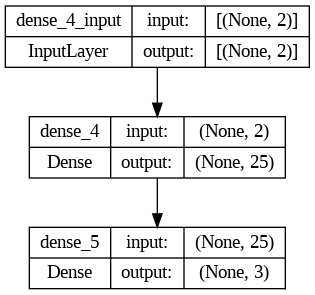

In [ ]:
# graph representation
from keras.utils import plot_model
plot_model(nn_model, show_shapes= True)

we now check the performance of the network

Train: 0.873, Val: 0.818, Test: 0.810


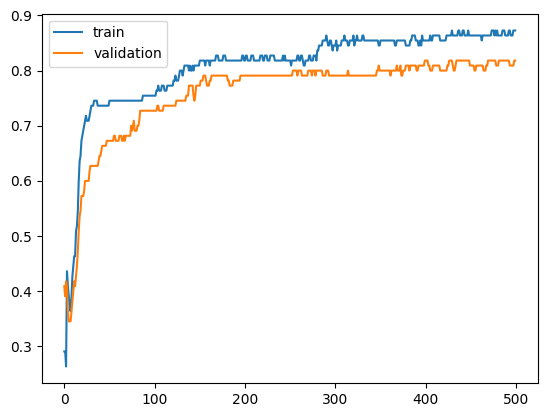

In [ ]:
_, train_acc = nn_model.evaluate(trainX, trainy_cat, verbose=0)
_, val_acc = nn_model.evaluate(valX, valy_cat, verbose=0)
_, test_acc = nn_model.evaluate(testX, testy_cat, verbose=0)
print('Train: %.3f, Val: %.3f, Test: %.3f' % (train_acc, val_acc, test_acc))
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='validation')
pyplot.legend()
pyplot.show()

**Exercise 2.2**

Initialise a decision tree (use *dt_model* as variable name) using random_state=123, setting maximum depth to 2 and using the default splitting criterion.

Train *dt_model* on trainX.

In [ ]:
# Add your code here
# define the model
dt_model = DecisionTreeClassifier(max_depth = 2, random_state = 123)
dt_model.fit(trainX, trainy)

DecisionTreeClassifier(max_depth=2, random_state=123)

We check the accuracy on train, validation and test; we extract the probabilities for each class.

In [ ]:
print('Train: %.3f, Val: %.3f, Test: %.3f' % (dt_model.score(trainX, trainy), dt_model.score(valX, valy), dt_model.score(testX, testy)))
nn_scores_train, nn_scores_val, nn_scores_test = (nn_model.predict(trainX), nn_model.predict(valX), nn_model.predict(testX))
dt_scores_train, dt_scores_val, dt_scores_test = (dt_model.predict_proba(trainX), dt_model.predict_proba(valX), dt_model.predict_proba(testX))


Train: 0.836, Val: 0.709, Test: 0.773
28/28 [==============================] - 0s 1ms/step


 **Exercise 2.3**

 Let's consider a $\phi()$ function that maps an example of the dataset into 6 features:

1.   the probability of the example to belong to each class by the Neural Network model (first 3 features)
2.   the probability of the example to belong to each class by the Decision Tree (latest 3 features)

Let's create the corresponding training, validation and test datasets.
For the variable names, add the prefix "stacked_", for example stacked_X_train.

In [ ]:
# Add your code here
stacked_X_train = np.hstack((nn_scores_train, dt_scores_train))
stacked_X_val = np.hstack((nn_scores_val, dt_scores_val))
stacked_X_test = np.hstack((nn_scores_test, dt_scores_test))

In [ ]:
print(stacked_X_train.shape, stacked_X_val.shape, stacked_X_test.shape)

(110, 6) (110, 6) (880, 6)


**Exercise 2.4** We now train a Logistic Regression classifier on this new data we just created. Specifically, we set the maximum iterations to 500 and fit_intercept=True. We select the best value of the C parameter, among 0.001, 0.01, 0.1, 1, 10, 100, 1000, with respect to its accuracy on the validation set.
Finally, we print the accuracy of the best model (trained on the training set only) on the validation and test sets.


In [ ]:
# Add your code here

C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
best_accuracy = 0

for value in C_values:
  lr = LogisticRegression(max_iter = 500, fit_intercept = True, random_state = 123, C = value)
  lr.fit(stacked_X_train, trainy)
  y_pred_val = lr.predict(stacked_X_val)
  model_accuracy = accuracy_score(valy, y_pred_val)
  if model_accuracy > best_accuracy:
    best_accuracy = model_accuracy
    best_C = value
print("The best value of C is {}, and it's accuracy is {}".format(best_C, best_accuracy))



#now use the best C to retrain the model
new_lr = LogisticRegression(max_iter = 500, fit_intercept = True, random_state = 123, C = best_C)

#fit the new model
new_lr.fit(stacked_X_train, trainy)

#accuracy of validation set
y_pred_val = new_lr.predict(stacked_X_val)
print(accuracy_score(valy, y_pred_val))

#accuracy of test set
y_pred_test = new_lr.predict(stacked_X_test)
print(accuracy_score(testy, y_pred_test))

The best value of C is 100, and it's accuracy is 0.8090909090909091
0.8090909090909091
0.8136363636363636
